In [1]:
import torch
import numpy as np
import torchvision
from torchvision import transforms
from pytorch_lightning import Trainer

from matplotlib import pyplot as plt

from datasets import Faces
from models import VanillaAE

In [2]:
model = VanillaAE((3, 45, 45), net_type='fc', dataset_name='faces')
trainer = Trainer(gpus=1, max_epochs=30)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


# Logging and visualizations
Model logs losses and recovered images into **TensorBoard**.  
Losses are logged every batch for both train and val datasets.  
Recovered images are logged after each epoch only for images in val dataset.  

In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4696), started 0:02:15 ago. (Use '!kill 4696' to kill it.)

In [5]:
trainer.fit(model)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 3 M   
1 | decoder | Decoder | 3 M   


1

# Sampling

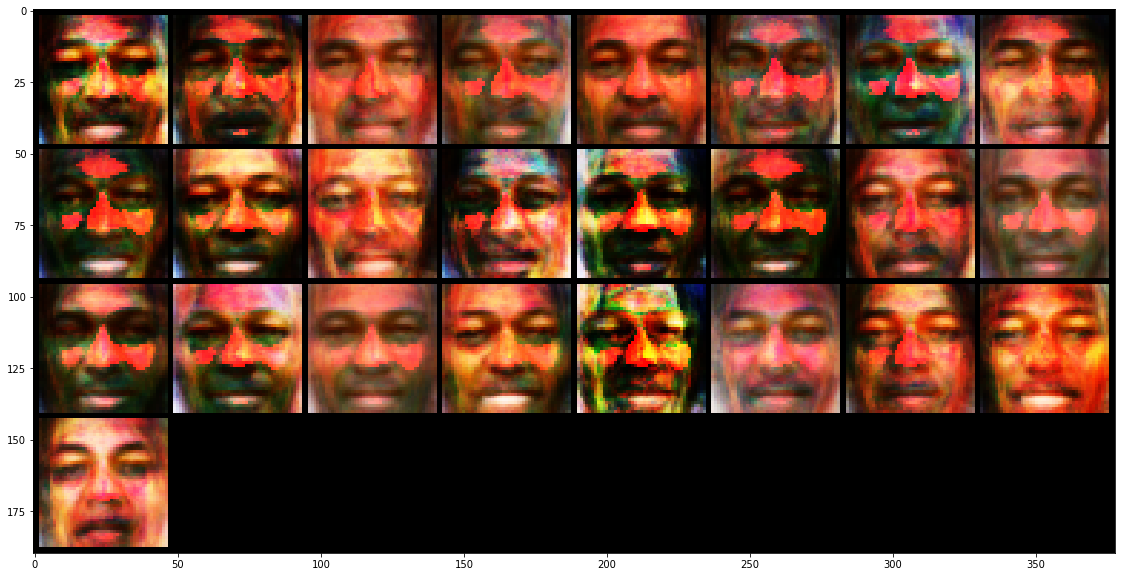

In [7]:
model.eval()
transforms_ = transforms.Compose([transforms.ToTensor()])
z = np.random.randn(25, 128)             # For fully-connected AE
#z = np.random.randn(25, 4, 11, 11)        # For convolutional AE
z = torch.from_numpy(z).float().to('cuda')
z = model.decoder(z)
grid = torchvision.utils.make_grid(z).detach().cpu()
plt.figure(figsize=(20,10))
plt.imshow(grid.permute(1, 2, 0))

# Smiling

In [8]:
transforms_ = transforms.Compose([transforms.ToTensor()])
dataset = Faces('images/faces/', transforms_)

# Extracting happy and sad people
happy_faces = []
sad_faces = []
for x in dataset:
    if x[1]['Smiling'] >= 1.5 and len(happy_faces) < 15:
        happy_faces.append(x[0])
    elif x[1]['Smiling'] <= -1 and len(sad_faces) < 15:
        sad_faces.append(x[0])
        
    if len(happy_faces) >= 15 and len(sad_faces) >= 15:
        break
happy_faces = torch.stack(happy_faces)
sad_faces = torch.stack(sad_faces)

In [9]:
model.eval()
happy_vector = model.encoder(happy_faces.to('cuda'))
sad_vector = model.encoder(sad_faces.to('cuda'))
smile_vector = torch.abs(happy_vector.mean(0) - sad_vector.mean(0))

In [10]:
not_sad_faces = model.decoder(sad_vector + smile_vector)

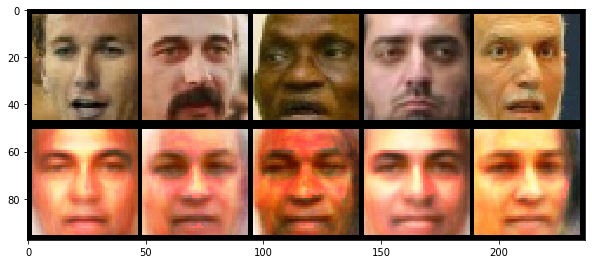

In [12]:
sad_grid = torchvision.utils.make_grid(sad_faces[:5]).detach().cpu()
not_sad_grid = torchvision.utils.make_grid(not_sad_faces[:5]).detach().cpu()
plt.figure(figsize=(10,10))
grid = torch.cat((sad_grid, not_sad_grid), 1)
plt.imshow(grid.permute(1, 2, 0))